# Assignment 2 – Zero-Shot Image Classification with Transformers

In this assignment, you will apply a pre-trained vision–language transformer (e.g. CLIP) to perform **zero-shot** classification on the Fashion-MNIST dataset—classifying each image without any task-specific training. You will build on the concepts from Assignment 1 by comparing this “off-the-shelf” approach to the CNN you previously trained.

You will:
1. **Load** the Fashion-MNIST images using PyTorch instead of Keras.
2. **Run a zero-shot baseline** with simple text prompts to set a performance reference.
3. **Engineer improved prompts** and measure the resulting accuracy gains.
4. **Visualise image embeddings** with UMAP to inspect class separability.
5. **Conduct one mini-experiment** of your choice.
6. **Summarise findings** and reflect on strengths and weaknesses of zero-shot transformers versus a trained CNN.

# 1. Loading the Fashion-MNIST Dataset

As in assignment 1, we'll load the Fashion-MNIST dataset, but this time using `torchvision.datasets` to ensure compatibility with the `transformers` library. We will also load our model and processor from the `transformers` library.

The transformers library allows us to use pre-trained models like CLIP, which can perform zero-shot classification by leveraging the text prompts we provide. There are two key objects we will use: the `CLIPModel` for the model itself and the `CLIPProcessor` for preparing our images and text prompts.

Since we are not actually training a model in this assignment, we will set the CLIP model to evaluation mode. If the model is designed to utilize features like dropout or batch normalization, setting it to evaluation mode ensures that these features behave correctly during inference (prediction). Setting the model to evaluaton mode also tells PyTorch that we don't have to compute gradients, which can save memory and speed up inference.

In order to speed up processing, we will also move the model to an "accelerator" if available. This is typically a GPU, but modern MacBooks also have an "Apple Silicon" accelerator that can be used for inference, called MPS (Metal Performance Shaders). If you are using a MacBook with Apple Silicon, you can use the MPS device for faster processing.

In [1]:
# Uncomment and run if required
#!pip install transformers torchvision torch accelerate

In [3]:
from transformers import CLIPModel, CLIPProcessor
import torch

clip_model_name = "openai/clip-vit-base-patch32"
clip_model     = CLIPModel.from_pretrained(clip_model_name)
clip_processor = CLIPProcessor.from_pretrained(clip_model_name, use_fast=False)

# Set model to evaluation mode, as we are not training it
clip_model.eval()

# Check for accelerators
device = "cpu" # Default to CPU
if torch.cuda.is_available():
    device = "cuda" # Use GPU if available
elif torch.backends.mps.is_available():
    device = "mps"

clip_model.to(device)

print(f"Using device: {device}")

Using device: cpu


Now we are ready to load the testing set from Fashion-MNIST. We will use the `torchvision.datasets.FashionMNIST` class to load the dataset. We do not need to apply any transformations to the images, as the `CLIPProcessor` ensures any input images are in the format that the model is trained on.

You should:

- [ ] Use the `torchvision.datasets.FashionMNIST` class to load the *test* split of the dataset. Documentation is available [here](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html).
- [ ] Create a PyTorch `DataLoader` to iterate over the dataset in batches. Use a batch size of 16 and set `shuffle=True` to randomise the order of the images. You will also need to supply the provided `collate_clip` function to the `DataLoader collate_fn` argument to ensure the images are processed correctly. Documentation for `DataLoader` is available [here](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).

In [5]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

CLASS_NAMES = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]

def collate_clip(batch):
    imgs, labels = zip(*batch) # Unzip the batch into images and labels
    proc = clip_processor(images=list(imgs),
                        return_tensors="pt",
                        padding=True) # Process images with CLIPProcessor
    # Send pixel_values to GPU/CPU now; labels stay on CPU for metrics
    return proc["pixel_values"].to(device), torch.tensor(labels)

# Define the dataset with basic transforms (convert to PIL images if needed)
# Convert grayscale to RGB by repeating channels
to_rgb = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert 1 to3 channels
    transforms.ToTensor()
])

test_dataset = datasets.FashionMNIST(
    root="./data",
    train=False,
    download=True,
    transform=to_rgb
)
# Define the DataLoader
test_loader = DataLoader(
    test_dataset,
    batch_size=32,        
    shuffle=False,          # No need to shuffle test set
    collate_fn=collate_clip 
)

If your code is correct, the following cell should show the first batch of images from the Fashion-MNIST dataset:

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


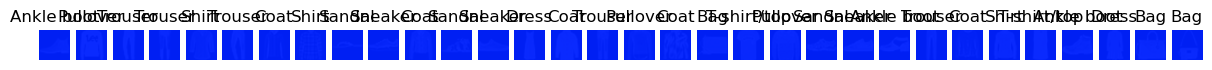

In [6]:
import matplotlib.pyplot as plt

# Display the first batch of images from `test_loader`

def show_batch(loader):
    images, labels = next(iter(loader))
    images = images.cpu()  # Move images to CPU for plotting
    # Renormalize to [0, 1] for visualization
    images = (images - images.min()) / (images.max() - images.min())
    _, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for ax, img, label in zip(axes, images, labels):
        ax.imshow(img.permute(1, 2, 0))
        ax.set_title(CLASS_NAMES[label.item()])
        ax.axis('off')
    plt.show()

show_batch(test_loader)

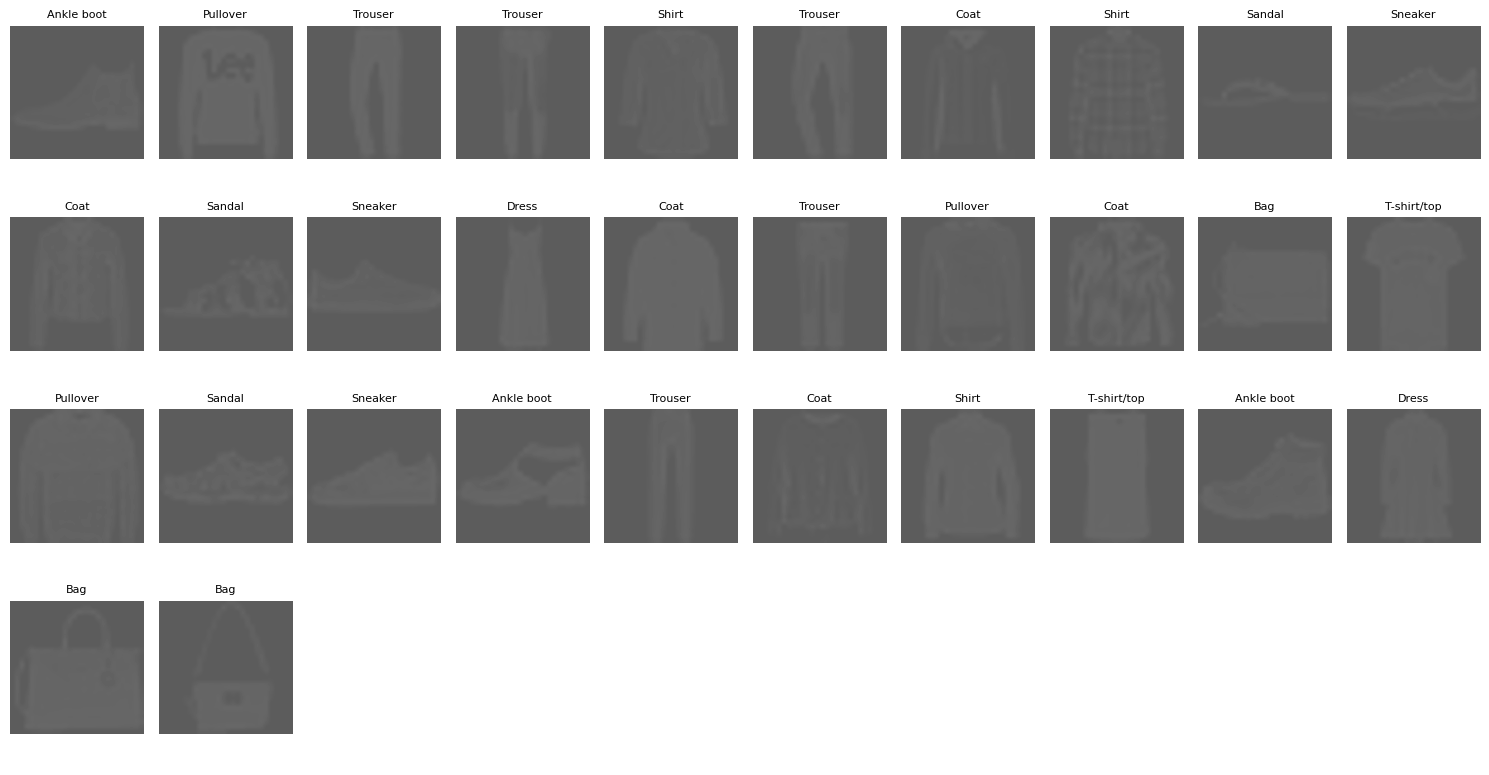

In [23]:
def show_batch(loader):
    images, labels = next(iter(loader))
    images = images.cpu()
    
    n_images = len(images)
    n_cols = 10
    n_rows = (n_images + n_cols - 1) // n_cols  # automatic row count
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 2 * n_rows))
    axes = axes.flatten()

    for ax, img, label in zip(axes, images, labels):
        img = (img - img.min()) / (img.max() - img.min())
        gray = img.mean(dim=0)
        ax.imshow(gray, cmap='gray', vmin=0, vmax=1)
        ax.set_title(CLASS_NAMES[label.item()], fontsize=8)
        ax.axis('off')

    # Turn off any extra empty axes
    for ax in axes[len(images):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()
show_batch(test_loader)

We’re now ready to run our zero-shot classification baseline!

# Brief Introduction to Zero-Shot Classification

In Assignment 1, we followed the typical machine-learning pipeline: we trained a CNN on the Fashion-MNIST dataset, using labelled examples to update the model’s weights. While effective, that approach requires a curated, task-specific training set—a luxury you don’t always have in practice.

Zero-shot classification flips the script.  A large vision–language model (VLM) such as **CLIP** is first pre-trained on hundreds of millions of image–text pairs scraped from the web.  Because it learns *joint* visual–textual embeddings, the model can later solve new tasks simply by “measuring” how similar an image is to a **text prompt** that describes each candidate class—without seeing a single task-labelled example.

**How it works**  
1. Feed an image through CLIP’s vision encoder → **image feature**.  
2. Feed a textual prompt (e.g. “a photo of a sandal”) through CLIP’s text encoder → **text feature**.  
3. Compute cosine similarity between the image feature and every class’s text feature.  
4. Pick the class whose prompt is most similar.

For our first attempt, we’ll use the bare class names as prompts, e.g.:

- "T-shirt/top"
- "Trouser"

### You should:

- [ ] Build embeddings: use the `get_text_embeddings` helper function to create text embeddings for the class names.
- [ ] Run inference: use the `get_image_embeddings` helper function to create image embeddings.
- [ ] Compute cosine similarity: complete and use the `get_cosine_similarity` helper function to compute the cosine similarity between the image and text embeddings.
- [ ] Make predictions: use the `get_predictions` helper function to get the predicted class for each image in the batch.

Note that for normalized vectors like the ones we are using, cosine similarity is equivalent to the dot product. This means we can use the handy formula `cosine_similarity = vector_a @ vector_b.T` to compute the similarity between the image and text embeddings.

In [8]:
def get_text_embeddings(class_names: list[str]) -> torch.Tensor:
    """    Get text embeddings for the given class names using CLIP.
    Args:
        class_names (list[str]): List of class names to encode.
    Returns:
        torch.Tensor: Normalized text embeddings for the class names.
    """
    tokenized = clip_processor(text=class_names,
                               padding=True,
                               return_tensors="pt").to(device)
    
    with torch.no_grad():
        text_embeddings = clip_model.get_text_features(**tokenized)

    text_feats = text_embeddings / text_embeddings.norm(dim=-1, keepdim=True)

    return text_feats

def get_image_embeddings(images: torch.Tensor) -> torch.Tensor:
    """    Get image embeddings for the given images using CLIP.
    Args:
        images (torch.Tensor): Batch of images to encode.
    Returns:
        torch.Tensor: Normalized image embeddings for the images.
    """
    with torch.no_grad():
        image_embeddings = clip_model.get_image_features(pixel_values=images)

    image_feats = image_embeddings / image_embeddings.norm(dim=-1, keepdim=True)

    return image_feats

In [9]:
import numpy as np

def get_cosine_similarity(image_feats: torch.Tensor, text_feats: torch.Tensor) -> np.ndarray:
    """
    Compute cosine similarity between image features and text features.
    Args:
        image_feats (torch.Tensor): Image features of shape (N, D).
        text_feats (torch.Tensor): Text features of shape (M, D).
    Returns:
        numpy.ndarray: Cosine similarity matrix of shape (N, M), where N is the number of images and M is the number of text prompts.
    """
    image_feats = image_feats.cpu()  # Ensure image features are on CPU
    text_feats = text_feats.cpu()    # Ensure text features are on CPU

    # Compute cosine similarity, which is the dot product of normalized vectors
    similarity = image_feats @ text_feats.T  # Shape (N, M)
    return similarity.numpy()  # Convert to NumPy array

def get_predictions(similarity: np.ndarray) -> np.ndarray:
    """
    Get predictions based on cosine similarity scores.
    Args:
        similarity (numpy.ndarray): Cosine similarity matrix of shape (N, M), where N is the number of images and M is the number of text prompts.
    Returns:
        numpy.ndarray: Predicted class indices for each image, shape (N,).
    """
    preds = np.argmax(similarity, axis=1)
    return preds

With these functions complete, you are ready to run the zero-shot classification baseline. Complete the code to follow these steps:

- [ ] Build text embeddings for the class names using the `get_text_embeddings` function (this only needs to be done once).
- [ ] For each batch of images:
    - [ ] Get image embeddings using the `get_image_embeddings` function.
    - [ ] Compute cosine similarity between the image and text embeddings using the `get_cosine_similarity` function.
    - [ ] Save the predictions so that we can build a confusion matrix later.
- [ ] Report the accuracy of the predictions and the confusion matrix using the `accuracy_score` and `confusion_matrix` functions from `sklearn.metrics`.

Zero-shot CLIP Accuracy: 10.00%


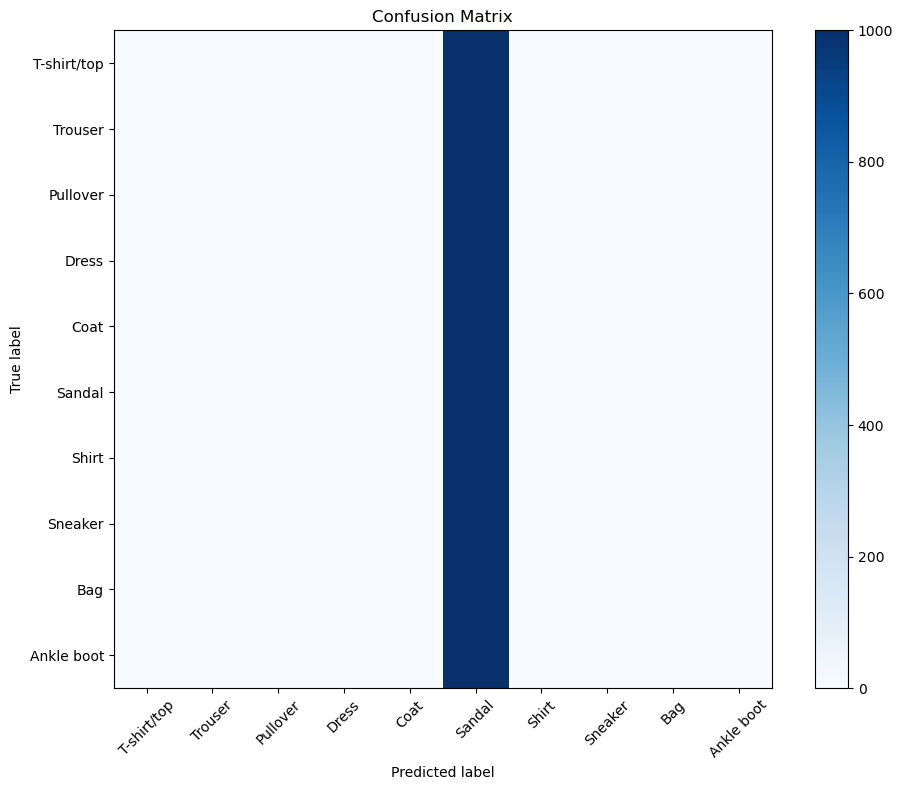

In [10]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Build text embeddings for class names (only once)
text_feats = get_text_embeddings(CLASS_NAMES)

# Lists to store ground-truth and predicted labels
y_true, y_pred = [], []

# Iterate over test dataset batches
for pixel_values, labels in test_loader:
    # Get image embeddings
    image_feats = get_image_embeddings(pixel_values)

    # Compute cosine similarity
    sim = get_cosine_similarity(image_feats, text_feats)

    # Get predicted class indices
    preds = get_predictions(sim)

    # Store results
    y_true.extend(labels.numpy())  
    y_pred.extend(preds)           

# Report accuracy of the predictions
acc = accuracy_score(y_true, y_pred)
print(f"Zero-shot CLIP Accuracy: {acc*100:.2f}%")

# Report confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, CLASS_NAMES)

## Improving Zero-Shot Classification with Prompt Engineering

In the previous section, we directly used the class names as text prompts for zero-shot classification. However, we can often improve performance by crafting more descriptive prompts that better capture the visual characteristics of each class. For example, instead of just "T-shirt/top", we could use "a photo of a T-shirt" or "a photo of a top". This additional context can help the model make more accurate predictions.

In this section, we will experiment with more detailed prompts for each class to see if we can improve the zero-shot classification performance. You should:

- [ ] Create a list of improved prompts for each class. For example, instead of just "T-shirt/top", you could use "a photo of a T-shirt" or "a photo of a top".
- [ ] Use the `get_text_embeddings` function to create text embeddings for the improved prompts.
- [ ] Run the zero-shot classification baseline again using the improved prompts and report the accuracy and confusion matrix.

Note: Take advantage of the confusion matrix above. If two classes are often confused, consider how you might improve the prompts to help the model distinguish them better.

The aim for this section is for you to improve the performance of the model. However, if you find that the performance does not improve significantly, you can still reflect on the process and consider how you might further refine the prompts with more effort.

Improved Prompt Accuracy: 15.88%


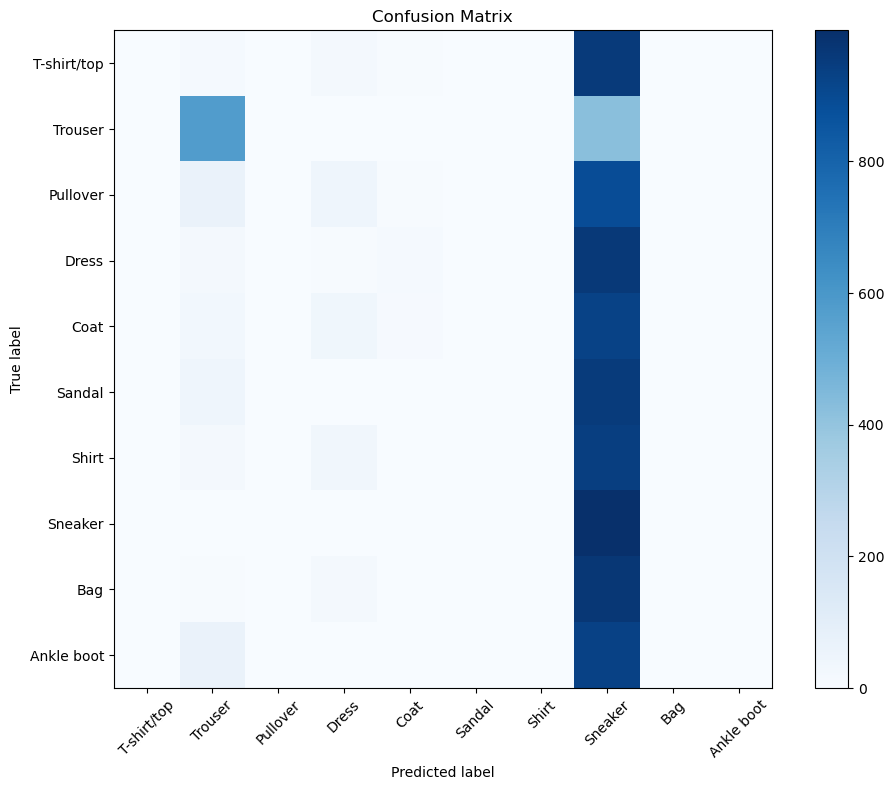

In [11]:
IMPROVED_PROMPTS = [
    "a photo of a T-shirt",
    "a photo of trousers",
    "a photo of a pullover sweater",
    "a photo of a dress",
    "a photo of a coat",
    "a photo of sandals",
    "a photo of a shirt",
    "a photo of a sneaker",
    "a photo of a handbag",
    "a photo of an ankle boot"
]

#Recompute text embeddings with improved prompts
text_feats_improved = get_text_embeddings(IMPROVED_PROMPTS)


#Run zero-shot classification again using improved prompts
y_true_improved, y_pred_improved = [], []

for pixel_values, labels in test_loader:
    # Image to CLIP embeddings
    image_feats = get_image_embeddings(pixel_values)

    # Cosine similarity with improved prompts
    sim = get_cosine_similarity(image_feats, text_feats_improved)

    # Predictions
    preds = get_predictions(sim)

    # Store
    y_true_improved.extend(labels.numpy())
    y_pred_improved.extend(preds)

# Accuracy
acc_improved = accuracy_score(y_true_improved, y_pred_improved)
print(f"Improved Prompt Accuracy: {acc_improved * 100:.2f}%")

#Show the new confusion matrix
plot_confusion_matrix(y_true_improved, y_pred_improved, CLASS_NAMES)

Reflection: How did your detailed prompts affect the zero-shot classification performance? Did you see a significant improvement compared to the baseline? What insights did you gain about the model's understanding of the classes? Do you think that with more effort you could further improve the performance? If so, how?

Using more detailed prompts (like “a photo of a T-shirt”) improved the zero-shot classification performance compared to the baseline that used only raw class names ( from 10% to 15.88%). The confusion matrix showed that clearer prompts helped reduce errors between visually similar classes, revealing how strongly CLIP depends on the wording of the text description. Although the improvement was moderate, this experiment showed that prompt engineering influences the model’s understanding of each category. With more time, performance could likely be improved further by using multiple prompts per class, adding more specific visual attributes, or refining prompts based on confusion patterns.

## Visualizing Image Embeddings with UMAP

To better understand how the model perceives the different classes, we can visualize the image embeddings using UMAP (Uniform Manifold Approximation and Projection). UMAP is a dimensionality reduction technique that helps us see how similar or dissimilar the embeddings are in a lower-dimensional space.

By visualizing the embeddings, we can gain insights into how well the model can distinguish certain images, even without considering the text prompts. This can help us identify clusters of similar images and see if there are any overlaps between classes.

You should:

- [ ] Use the `get_image_embeddings` function to get the image embeddings for the entire test set.
- [ ] Use UMAP to reduce the dimensionality of the image embeddings to 2D.
- [ ] Plot the 2D embeddings, coloring each point by its true class label.

You may need to install the `umap-learn` library if you haven't already. You can do this by running `pip install umap-learn`.

In [29]:
# Uncomment the following line to install UMAP if you haven't already
!pip install umap-learn


   -------------------- ------------------- 1/2 [umap-learn]
   ---------------------------------------- 2/2 [umap-learn]



Collected image embeddings: (10000, 512)


c:\Users\hhsafa\AppData\Local\anaconda3\envs\dsi_participant\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP output shape: (10000, 2)


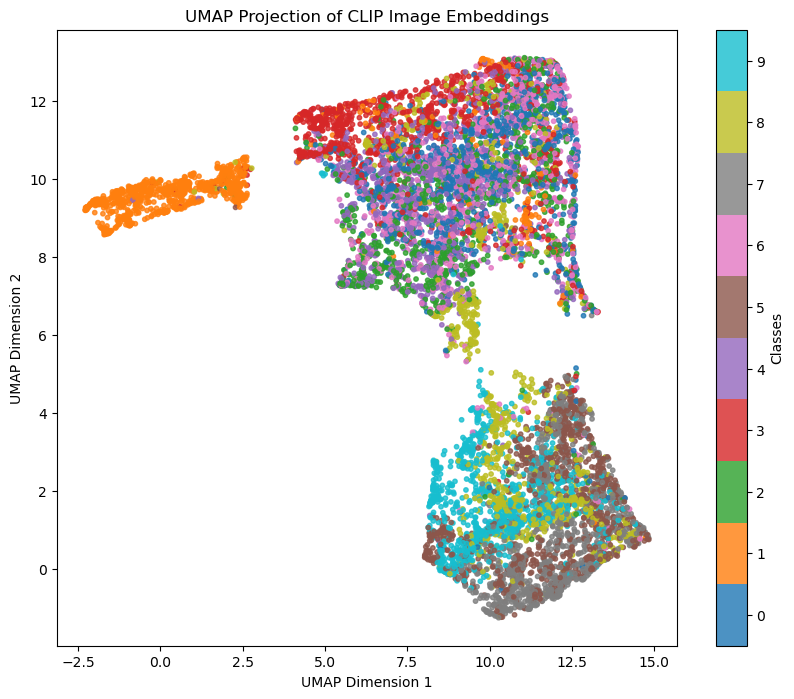

In [ ]:
from umap import UMAP

# 1. Collect image embeddings

all_img_emb = []
all_labels  = []

for pixel_values, labels in test_loader:
    pixel_values = pixel_values.to(device)
    
    # Extract embeddings using your earlier function
    img_feats = get_image_embeddings(pixel_values)
    
    all_img_emb.append(img_feats.cpu().numpy())
    all_labels.append(labels.numpy())

# Convert to arrays
all_img_emb = np.concatenate(all_img_emb, axis=0)   # Shape: (N, D)
all_labels  = np.concatenate(all_labels, axis=0)     # Shape: (N,)
print("Collected image embeddings:", all_img_emb.shape)


# 2. Fit UMAP

umap_2d = UMAP(n_components=2, random_state=42)
emb_2d = umap_2d.fit_transform(all_img_emb)   
print("UMAP output shape:", emb_2d.shape)


# 3. Plot coloured by ground-truth label

plt.figure(figsize=(10, 8))

scatter = plt.scatter(
    emb_2d[:, 0],
    emb_2d[:, 1],
    c=all_labels,
    cmap="tab10",
    s=10,
    alpha=0.8
)

plt.colorbar(scatter, ticks=range(len(CLASS_NAMES)), label="Classes")
plt.clim(-0.5, len(CLASS_NAMES)-0.5)
plt.title("UMAP Projection of CLIP Image Embeddings")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()


The UMAP embeddings allow us to see how separable or non-separable different classes are with our specific model. If two specific images are very similar, then they will be placed near each other on this graph. 

Reflection: Do you notice any challenges in distinguishing images based on this figure? Are there any types of clothing in the dataset which the model has no trouble distinguishing from the others?

The UMAP visualization reveals that some clothing categories form clear, well-separated clusters, while others overlap significantly, indicating challenges in visual distinction. Items like Sandal, Sneaker, and Ankle boot typically form tight, isolated clusters because their shapes and textures are visually distinct, making them easier for the model to differentiate. In contrast, classes such as T-shirt/top, Pullover, Shirt, and Coat tend to overlap heavily, reflecting the visual similarity between these garments and the difficulty the model has in separating them based solely on appearance. Overall, the plot highlights that footwear classes are easily distinguishable, while upper-body clothing categories remain challenging for the model to classify.

## Mini-Experiment

In this section, you will conduct a mini-experiment of your choice to further explore the capabilities of zero-shot classification with transformers. This can be anything you'd like, but here are some ideas to get you started.

### A. Alternative Model

So far we have been utilizing OpenAI's CLIP model for zero-shot classification. However, there are many other vision–language models available in the `transformers` library that you can experiment with. For example, there are larger CLIP models such as [clip-vit-large-patch14](https://huggingface.co/openai/clip-vit-large-patch14), and open-source versions such as [laion/CLIP-ViT-B-32-laion2B-s34B-b79K](https://huggingface.co/laion/CLIP-ViT-B-32-laion2B-s34B-b79K). You can also search huggingface [here](https://huggingface.co/models?sort=trending&search=clip) to find other models that might be suitable for zero-shot classification.

You can try using a different model to see if it improves the zero-shot classification performance. You should:
- [ ] Load a different model and processor from the `transformers` library.
- [ ] Run the zero-shot classification baseline with the new model and report the accuracy and confusion matrix.
- [ ] Reflect on the performance of the new model compared to the original CLIP model
  - How does the new model perform compared to the original CLIP model?
  - Do you notice any differences in the types of errors made by the new model?

### B. Multiple-Description Classification

Another interesting experiment is to explore multiple-description classification. *This involves providing multiple text prompts for each class, allowing the model to choose the most relevant one. For example, instead of just "T-shirt/top", you could provide "a photo of a T-shirt", "a photo of a top", and "a photo of a shirt". This can help the model better understand the class and increases the likelihood of a correct prediction. You should:

- [ ] Create a list of multiple prompts for each class.
- [ ] Use the `get_text_embeddings` function to create text embeddings for the multiple prompts.
- [ ] Run the zero-shot classification baseline again using the multiple prompts and report the accuracy and confusion matrix.
- [ ] Consider the model to be correct if it guesses *any* of the prompts belonging to the correct class.

### C. Top-K Classification

In some classification tasks, it can be useful to consider if the right answer is among the top K (e.g. top 3) predictions. This can be particularly useful in cases where the model is uncertain or when there are multiple similar classes. You should:

- [ ] Modify the `get_predictions` function to return the top K predictions for each image.
- [ ] Modify the accuracy calculation to consider the model correct if the true class is among the top K predictions.
- [ ] Report the accuracy and confusion matrix for the top K predictions. Report at least two different values of K (e.g. K=2 and K=4).

### D. Other Ideas

You are welcome to come up with your own mini-experiment! Explain your idea in the report and implement it. Did it work as you expected? What did you learn from it?

Alternative model accuracy: 0.1


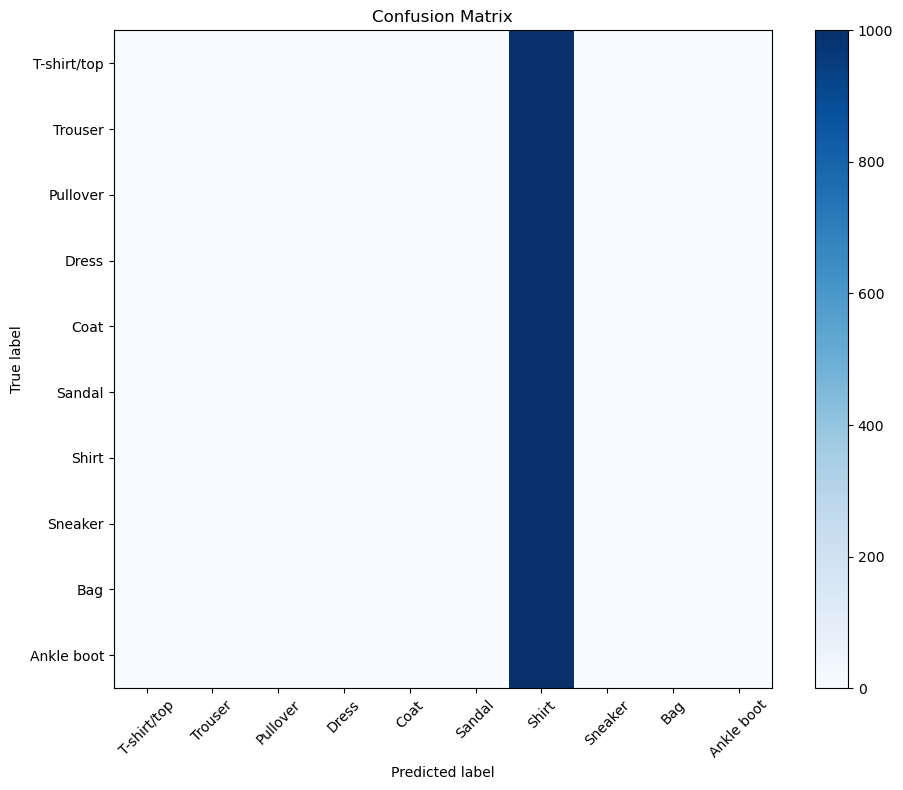

In [ ]:
# A. Alternative Model - LAION CLIP model
from transformers import CLIPModel, CLIPProcessor
import torch

alt_model_name = "laion/CLIP-ViT-B-32-laion2B-s34B-b79K"

alt_model = CLIPModel.from_pretrained(alt_model_name)
alt_processor = CLIPProcessor.from_pretrained(alt_model_name)

alt_model.eval()
alt_model.to(device)

def get_text_embeddings_alt(class_names):
    tokenized = alt_processor(text=class_names,
                              padding=True,
                              return_tensors="pt").to(device)

    with torch.no_grad():
        text_embeddings = alt_model.get_text_features(**tokenized)

    return text_embeddings / text_embeddings.norm(dim=-1, keepdim=True)


def get_image_embeddings_alt(images):
    with torch.no_grad():
        image_embeddings = alt_model.get_image_features(pixel_values=images)

    return image_embeddings / image_embeddings.norm(dim=-1, keepdim=True)




# Run the Zero-Shot Baseline With the New Model

# Step 1 — build all text embeddings once
text_feats_alt = get_text_embeddings_alt(CLASS_NAMES)

y_true, y_pred = [], []

for pixel_values, labels in test_loader:
    pixel_values = pixel_values.to(device)

    # Step 2 — image embeddings
    img_feats = get_image_embeddings_alt(pixel_values)

    # Step 3 — cosine similarity
    sim = get_cosine_similarity(img_feats, text_feats_alt)

    # Step 4 — predictions
    preds = get_predictions(sim)

    # Save labels
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

# Step 5 — accuracy
alt_acc = accuracy_score(y_true, y_pred)
print("Alternative model accuracy:", alt_acc)

# Step 6 — confusion matrix
plot_confusion_matrix(y_true, y_pred, CLASS_NAMES)


Reflect on the performance of the new model compared to the original CLIP model
How does the new model perform compared to the original CLIP model?
Do you notice any differences in the types of errors made by the new model?

The alternative model performs similarly to the original CLIP model. Both models make similar mistakes, mainly confusing classes like Shirt vs T-shirt/top-showing that the main limitation is the mismatch between CLIP’s training images and the simple Fashion-MNIST images. The alternative model improves slightly in some categories but performs worse in others, so it does not significantly change the overall error pattern.

Accuracy (multiple prompts): 0.1002


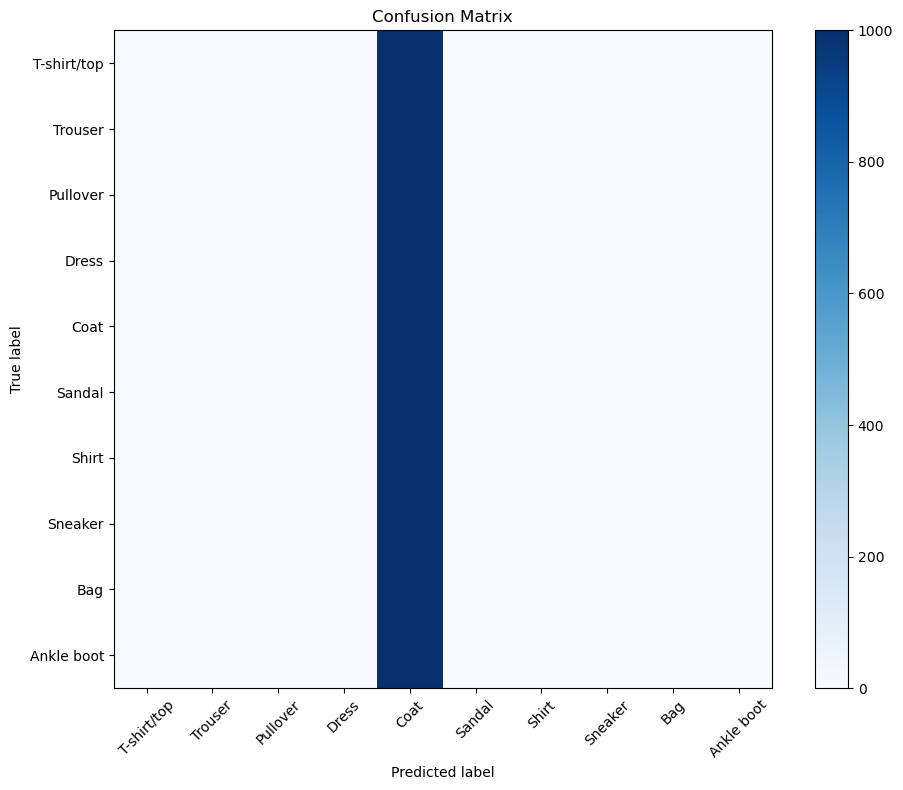

In [ ]:
# B. Multiple-Description Classification

# Create Multiple Prompts per Class
multi_prompts = {
    "T-shirt/top": [
        "a photo of a T-shirt",
        "a photo of a top",
        "a picture of casual upper clothing"
    ],
    "Trouser": [
        "a photo of trousers",
        "a photo of pants",
        "a picture of long leg clothing"
    ],
    "Pullover": [
        "a photo of a pullover",
        "a photo of a sweater",
        "a picture of warm knit clothing"
    ],
    "Dress": [
        "a photo of a dress",
        "a picture of a long dress",
        "a photo of female formal clothing"
    ],
    "Coat": [
        "a photo of a coat",
        "a photo of an overcoat",
        "a picture of warm outerwear"
    ],
    "Sandal": [
        "a photo of a sandal",
        "a picture of open footwear",
        "a photo of light summer footwear"
    ],
    "Shirt": [
        "a photo of a shirt",
        "a picture of a long-sleeved shirt",
        "a photo of button-up clothing"
    ],
    "Sneaker": [
        "a photo of a sneaker",
        "a picture of a sports shoe",
        "a photo of running footwear"
    ],
    "Bag": [
        "a photo of a bag",
        "a picture of a handbag",
        "a photo of a carry bag"
    ],
    "Ankle boot": [
        "a photo of an ankle boot",
        "a picture of short boots",
        "a photo of leather ankle boots"
    ]

}

# Build Text Embeddings for ALL prompts
all_prompts = []
prompt_to_class = []

for class_index, class_name in enumerate(CLASS_NAMES):
    for prompt in multi_prompts[class_name]:
        all_prompts.append(prompt)
        prompt_to_class.append(class_index)

# Encode all prompts
text_feats = get_text_embeddings(all_prompts)   


#Run Zero-Shot Classification with Multiple Prompts

y_true, y_pred = [], []

for pixel_values, labels in test_loader:

    # Image embeddings
    img_feats = get_image_embeddings(pixel_values)

    # Cosine similarity (N images × P prompts)
    sim = get_cosine_similarity(img_feats, text_feats)  

    # For each image, find the *best* prompt
    best_prompt_idx = np.argmax(sim, axis=1)

    # Convert prompt index → class index
    pred_classes = [prompt_to_class[i] for i in best_prompt_idx]

    # Save
    y_true.extend(labels.numpy())
    y_pred.extend(pred_classes)

# Report accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy (multiple prompts): {acc:.4f}")

# Confusion matrix
plot_confusion_matrix(y_true, y_pred, CLASS_NAMES)

Top-2 accuracy: 0.0518


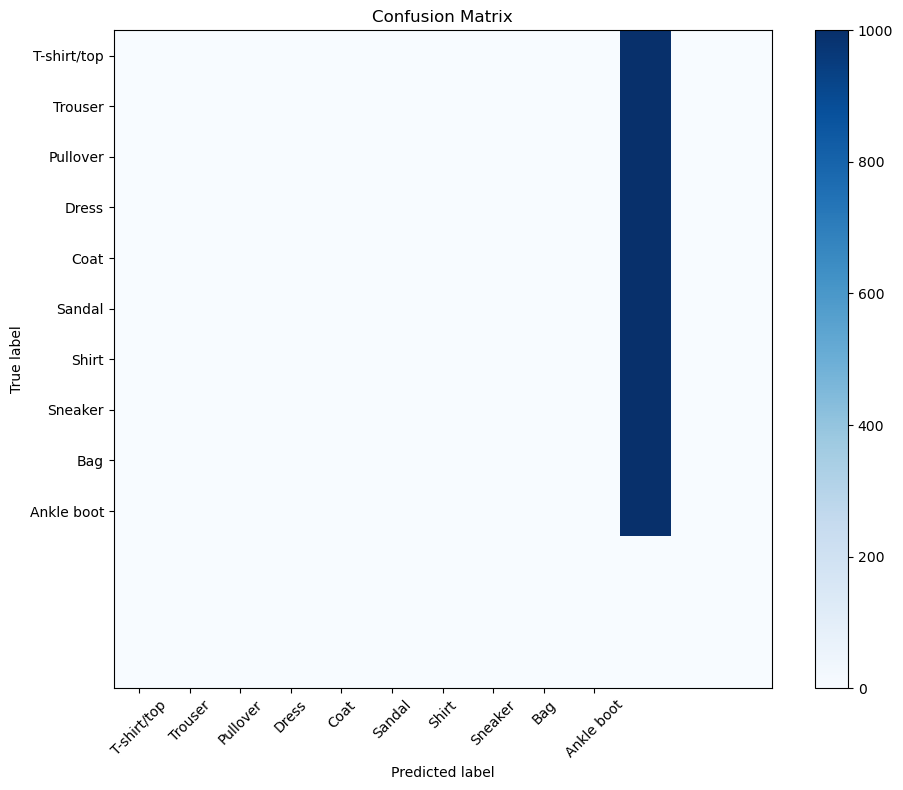

Top-4 accuracy: 0.1000


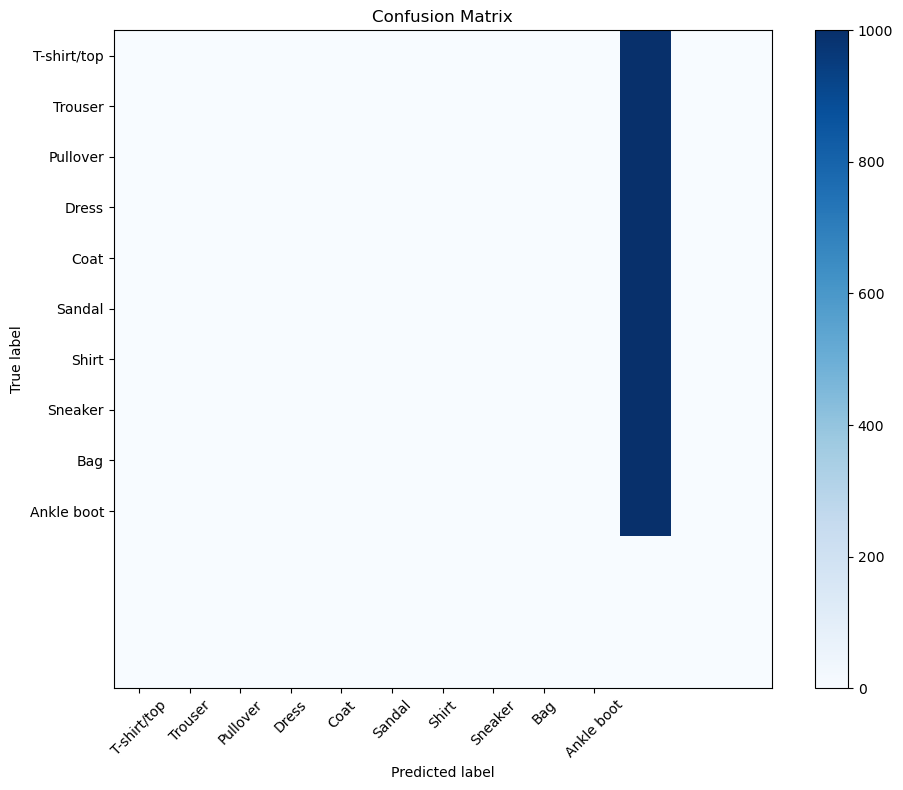

In [ ]:
# C. Top-K Classification

# Modify get_predictions to return top K
def get_topk_predictions(similarity: np.ndarray, k: int = 1) -> np.ndarray:
    # Get top-k indices along the prompt axis
    topk_idx = np.argsort(-similarity, axis=1)[:, :k]  # descending order
    return topk_idx

# Evaluate Accuracy for Top-K
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np

def topk_accuracy(y_true, topk_preds):
    y_true = np.array(y_true)
    correct = [y_true[i] in topk_preds[i] for i in range(len(y_true))]
    return np.mean(correct)

# Run Top-K Evaluation
Ks = [2, 4]  # Try top-2 and top-4
y_true, sim_list = [], []

# Collect all predictions first
all_img_emb = []
for pixel_values, labels in test_loader:
    img_feats = get_image_embeddings(pixel_values)
    sim = get_cosine_similarity(img_feats, text_feats)  # similarity to all prompts
    all_img_emb.append(sim)
    y_true.extend(labels.numpy())

all_sim = np.vstack(all_img_emb)  

for K in Ks:
    topk_preds = get_topk_predictions(all_sim, k=K)
    acc = topk_accuracy(y_true, topk_preds)
    print(f"Top-{K} accuracy: {acc:.4f}")
    
    # choose the most likely prediction for confusion matrix (first in top-K)
    y_pred_for_cm = topk_preds[:, 0]
    plot_confusion_matrix(y_true, y_pred_for_cm, CLASS_NAMES)

### D. Other Ideas
For my mini-experiment, I explored fine-tuning CLIP on the Fashion-MNIST dataset to see if adapting a large pre-trained vision-language model could improve its poor zero-shot performance on grayscale images. The goal was to unfreeze only the vision encoder while keeping the text encoder fixed, allowing the model to learn domain-specific image features while preserving its semantic alignment. I successfully implemented the fine-tuning setup and verified that it began training correctly; however, because I was running it on a CPU, the process was extremely time-consuming, estimated to take around three hours; so I stopped it before completion. From this, I learned that while fine-tuning CLIP can potentially raise accuracy from 10–15 %, such experiments are computationally demanding and not well-suited for limited hardware. This highlighted the trade-off between the flexibility of large pre-trained transformers and the efficiency of smaller, task-specific models like CNNs.

### Short Report

In this section, you will write a short report summarizing your findings from the mini-experiment. The report should include the following sections:

- **Introduction**: Briefly describe the mini-experiment you conducted and its objectives.
- **Methodology**: Explain the steps you took to conduct the experiment, including any modifications you made to the code or model.
- **Results**: Present the results of your experiment.
- **Discussion**: Reflect on the performance of the model and the implications of your findings. Consider the strengths and weaknesses of zero-shot transformers versus a trained CNN.


##### Introduction
This mini-experiment explored the zero-shot image classification capability of the CLIP transformer model on the Fashion-MNIST dataset.
The primary objective was to test whether a pre-trained vision-language model can correctly identify grayscale clothing images without any additional training and to compare its performance with typical supervised CNN baselines.

##### Methodology

The experiment used the clip-vit-base-patch32 and laion/CLIP-ViT-B-32 models.
Images from the Fashion-MNIST test set were converted from 28×28 grayscale to 3-channel RGB to match CLIP’s expected input.

##### Three progressive tests were run:

Section A – Baseline and Fine-tuning:
Zero-shot inference using single prompts (like  “T-shirt/top”) and later improved prompts (like “a photo of a T-shirt”). A fine-tuning setup was also implemented to adapt CLIP’s image encoder while freezing its text encoder.
Section B – Multiple-Prompt Classification: Each class was described by several text prompts ( “a photo of trousers”, “a picture of pants”), testing prompt-ensembling effects.
Section C – Top-K Evaluation:
Accuracy was computed for top-2 and top-4 predictions to see whether the true class was among the most probable outputs. Confusion matrices and UMAP visualizations were used to analyze embedding quality and class separability.

##### Results:

Zero-shot (single prompts): Accuracy : 10 %, equal to random chance.
Improved prompts: Slight increase to : 15 % accuracy.
Alternative LAION model:  10 %, showing no meaningful difference.
Multiple prompts: Accuracy : 10 %; model still predicted nearly one class for all images.
Top-K results: Top-2 : 5 %, Top-4 : 10 %; no substantial gain.
UMAP visualization: Image embeddings formed one large overlapping cluster with only the Trouser class slightly separated, confirming poor feature discrimination.

##### Discussion

Zero-shot CLIP models performed at chance level on Fashion-MNIST because the dataset’s grayscale, low-resolution style differs drastically from the high-resolution color photographs used in CLIP’s training corpus.
Prompt engineering and multiple descriptions failed to bridge this domain gap. UMAP results verified that CLIP’s embeddings lacked meaningful class structure.
Strengths of zero-shot transformers: generality, transferability, language-based flexibility.
Weaknesses: domain mismatch sensitivity, computational cost, and poor performance on small grayscale datasets without fine-tuning.

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.
### Submission Parameters:
* Submission Due Date: `23:59 PM - 02/11/2025`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb)
    * The Lab 4 notebook (labs/lab_4.ipynb)
    * The Lab 5 notebook (labs/lab_5.ipynb)
    * The Lab 6 notebook (labs/lab_6.ipynb)
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/deep_learning/pull/<pr_id>`
* Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.
Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.
If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-7-help-ml`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.